# Quantum Time Series Analysis: QNN Model
Compatible with Qiskit 1.2.4+

### Author
- October 2022: Prepared for Workshop on Quantum Machine Learning, 13 October 2022, organised in collaboration with QWorld, QPoland, QIndia and Quantum AI Foundation. In association with IEEE Conference Trends in Quantum Computing and Emerging Business Technologies - TQCEBT 2022
- May 2024: Compatibility upgrade to Qiskit 1.2.4+ 

### Aims
> *This script aims to fit time series data with quantum neural network.*

### Primary Sources
- Schreiber, Amelie. “Quantum Neural Networks for FinTech.” 
    Medium, May 8, 2020.<br/> 
    https://towardsdatascience.com/quantum-neural-networks-for-fintech-dddc6ac68dbf
- Qiskit Team. "Tutorial: Neural Network Classifier & Regressor", Last updated: 31 Aug 2022.<br/>
    https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/envs/qiskit-gpu/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.11/site-packages',
 '.']

In [2]:
import os
import numpy as np
import pylab
import math
import json
import time
from tqdm.notebook import tqdm

from IPython.display import clear_output

from utils.Target import *
from utils.Window import *
from utils.TS import *
from utils.Charts import *
from utils.Integrate import *
from utils.Files import *
from utils.Cost import *
from utils.Metrics import *

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
### Libraries used in QTSA development

from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_algorithms.optimizers import L_BFGS_B, P_BFGS, COBYLA, NELDER_MEAD, QNSPSA, ADAM, UMDA
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap,EfficientSU2, PauliFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.utils.loss_functions import L1Loss, L2Loss
from qiskit.circuit import Parameter
from qiskit.compiler import transpile

from sklearn.metrics import r2_score, mean_absolute_percentage_error 

In [4]:
### Listing control
debug = True
seed = 2022

### Software version
MAJOR = 9
MINOR = 0

### Constants
LOG_NAME = 'log_2'
CASE_NAME = 'qnn'
DATA_NAME = '2_sins_sw'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('log_2',
 'qnn',
 '2_sins_sw',
 'log_2/data',
 'log_2/training',
 'log_2/params',
 'log_2/analysis',
 'log_2/figures')

## Fetch data

In [5]:
### All created files have the following codes:
DATA_ID = '2_sins_sw_t50_v20_z0_w5_s1_h1'

### Define file names

x_all_fpath = f'{DATA_PATH}/{DATA_ID}/x_all.arr'
y_all_fpath = f'{DATA_PATH}/{DATA_ID}/y_all.arr'

x_train_ts_fpath = f'{DATA_PATH}/{DATA_ID}/x_train_ts.arr'
y_train_ts_fpath = f'{DATA_PATH}/{DATA_ID}/y_train_ts.arr'
x_valid_ts_fpath = f'{DATA_PATH}/{DATA_ID}/x_valid_ts.arr'
y_valid_ts_fpath = f'{DATA_PATH}/{DATA_ID}/y_valid_ts.arr'

data_info_fpath = f'{DATA_PATH}/{DATA_ID}/info.json'
data_info_fpath

'log_2/data/2_sins_sw_t50_v20_z0_w5_s1_h1/info.json'

In [6]:
### Load the info file
data_info = read_json_file(data_info_fpath)
    
### Get info details
DATA_NAME = data_info['data_name']
DATA_MAJOR = data_info['major_version'] 
DATA_MINOR = data_info['minor_version']
samples_train = data_info['data_train']
samples_valid = data_info['data_valid']
noise = data_info['data_noise']
wind_size = data_info['wind_size']
wind_step = data_info['wind_step']
horizon = data_info['wind_horizon']
seed = data_info['seed']
samples = samples_train + samples_valid
train_pc = samples_train / samples

print(f'\nSaved time series info in file "{data_info_fpath}":\n')
for k in data_info.keys():
    print(f'\tinfo[{k}] = {data_info[k]}')
print()
print(f'\tcalc[samples] = {samples}')
print(f'\tcalc[train_pc] = {train_pc}')
print()


Saved time series info in file "log_2/data/2_sins_sw_t50_v20_z0_w5_s1_h1/info.json":

	info[data_name] = 2_sins_sw
	info[major_version] = 9
	info[minor_version] = 0
	info[data_train] = 50
	info[data_valid] = 20
	info[data_noise] = 0
	info[wind_size] = 5
	info[wind_step] = 1
	info[wind_horizon] = 1
	info[seed] = 2022

	calc[samples] = 70
	calc[train_pc] = 0.7142857142857143



In [7]:
### Load data files
X_all = read_ts_file(x_all_fpath)[..., None]
y_all = read_ts_file(y_all_fpath)
X_train_ts = read_ts_file(x_train_ts_fpath)
y_train_ts = read_ts_file(y_train_ts_fpath)[..., None]
X_valid_ts = read_ts_file(x_valid_ts_fpath)
y_valid_ts = read_ts_file(y_valid_ts_fpath)[..., None]
print(f'\nLoaded time series data\n')


Loaded time series data





TS noise = 0%, calculated noise in differenced TS = 0.0%, total noise = 0.0, over the points = 46



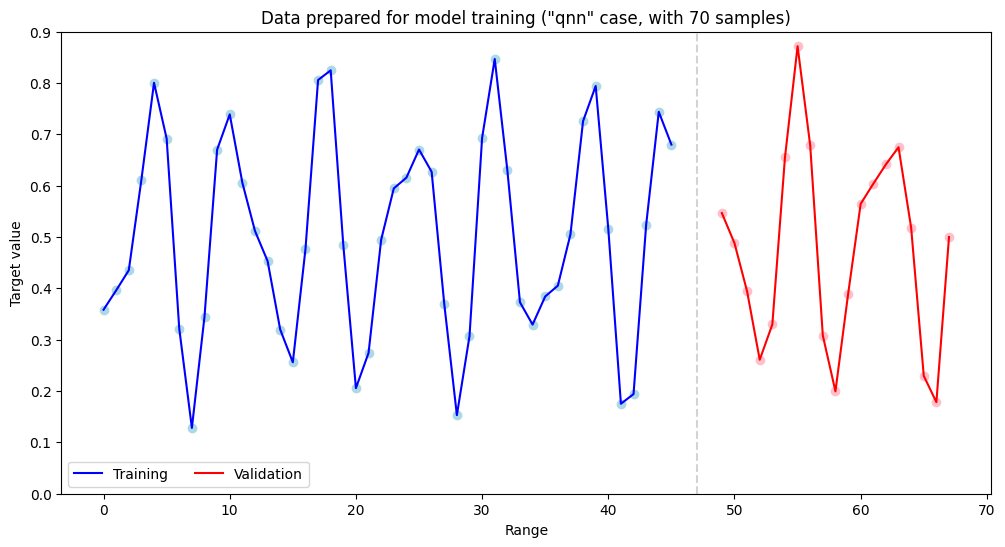

In [8]:
### Plot of training and validation data with noise
itg_integrated_plot(y_train_ts, y_valid_ts, y_train_ts, y_valid_ts, wind_step, noise,
     labels=['Training', 'Validation'], xlabel='Range', ylabel='Target value', ylim=(0, 0.9),
     title=f'Data prepared for model training ("{CASE_NAME}" case, with {samples} samples)',
     # line_styles={'train_pure':'solid', 'train_noisy':'none', 'valid_pure':'solid', 'valid_noisy':'none'},
     cols = {'train_pure':'blue', 'train_noisy':'lightblue', 'valid_pure':'red', 'valid_noisy':'pink'},
     marker_style='o')
print()

## Quantum Neural Network Qiskit Solution

### Identify device

In [9]:
### Find what devices are available
from qiskit_aer import Aer
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
print(f'Available quantum devices: {devices}')

### Priority GPU
device = 'GPU' if ('GPU' in devices) else 'CPU'

### Force CPU for this run
device = 'CPU'
device
print(f'Selected device: {device}')

Available quantum devices: ('CPU', 'GPU')
Selected device: CPU


In [10]:
### Create a sampler/estimator suitable for the device
#   GPU methods: statevector, tensor_network, density_matrix, unitary

from qiskit.primitives import Sampler, Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Sampler as AerSampler, Estimator as AerEstimator # For device="GPU" option

seed = 2022
shots = 10000

if device == 'GPU':
    sampler = AerSampler(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
    
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': shots},
        transpile_options={'seed_transpiler': seed},
    )
else:
    sampler = Sampler()
    estimator = Estimator()

### QNN circuit
**<font color="red">Note:</font>** *Function "swindow_qnn_model" has a mispelled variables qubit_no/qubits_no, however, it seemed to work as the outside context defined the missing variable. It was addressed in the "qtsa_04_qnn_v9.6_analysis" notebook. It needs to be addressed in the new version, yet it was left as is to ensure replication of results, will need to test if changes will produce the same or very close results.*


Example: Inputs#=5, Qubits#=9, Weight params#=162, FM Layer#=1, ANZ Layer#=5




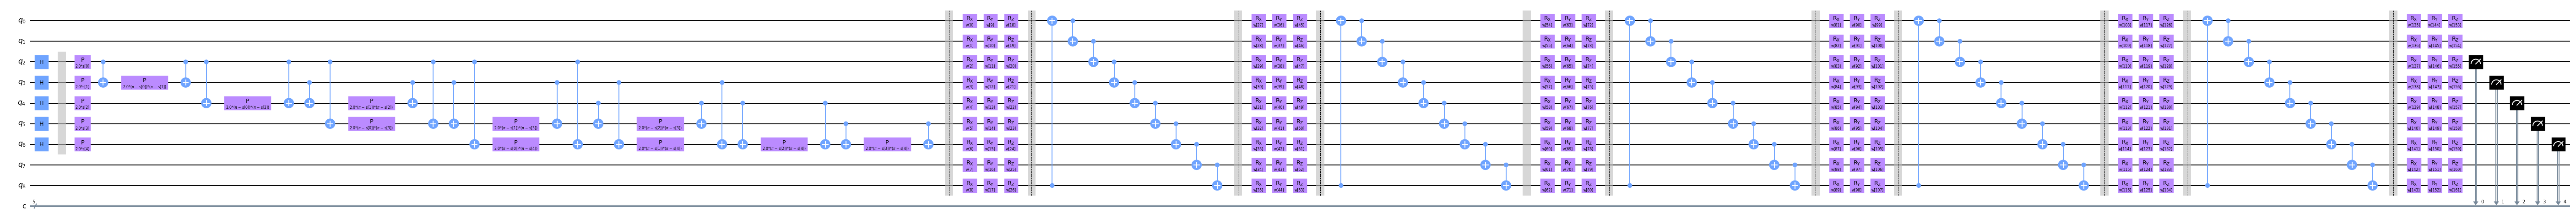

In [13]:
### Sliding window QNN model
def swindow_qnn_model(qubits_no, input_no, fm_layers_no, ans_layers_no, ent='full', 
                      insert_barriers=True, add_meas=False):

    fm_map = ZZFeatureMap(input_no, reps=fm_layers_no, insert_barriers=insert_barriers, parameter_prefix='s')
    # ansatz = RealAmplitudes(qubits_no, entanglement=ent, reps=ans_layers_no, insert_barriers=insert_barriers, parameter_prefix='w')
    ansatz = TwoLocal(qubit_no, ['rx', 'ry', 'rz'], 'cx', 
             entanglement=ent,
             reps=ans_layers_no, 
             parameter_prefix='w', 
             insert_barriers=True,
             skip_final_rotation_layer=False)
    fm_start_qubit = (qubits_no-input_no)//2
    fm_end_qubit = fm_start_qubit+input_no
    
    if add_meas:
        circ = QuantumCircuit(qubits_no, input_no, name="circ")
    else:
        circ = QuantumCircuit(qubits_no, name="circ")

    if qubit_no < input_no:
        return circ, fm_map.parameters, ansatz.parameters

    circ.append(fm_map, qargs=range(fm_start_qubit, fm_end_qubit))
    circ.barrier()
    circ.append(ansatz, qargs=ansatz.qubits)
    if add_meas:
        for q in range(input_no):
            #print(fm_start_qubit+q, q)
            circ.measure(fm_start_qubit+q, q)
    return circ.decompose().decompose(), fm_map.parameters, ansatz.parameters

# Test a sample QNN model
qubit_no = 9; input_no = 5; fm_layers_no = 1; anz_layers_no = 5; ent = 'circular'
m, input_params, weight_params = swindow_qnn_model(qubit_no, input_no, fm_layers_no, anz_layers_no, 
    ent=ent, add_meas=True)

# print(f'QNN Params: {m.parameters}\n')
# print(f'Input params:\n{input_params}')
# print(f'\nWeight params:\n{weight_params}')
print(f'\nExample: Inputs#={len(input_params)}, Qubits#={qubit_no}, Weight params#={len(weight_params)}, FM Layer#={fm_layers_no}, ANZ Layer#={anz_layers_no}')

print()
m.draw(output='mpl', style='clifford', fold=False, scale=0.7)
print()

## Create and train the model

In [14]:
# Define model parameters and their initial values (including random input)

epochs = 80
log_interval = 1
prompt_interval = 4
qubits = 9
inputs = wind_size
fm_layers = 1
anz_layers = 5
ent = 'circular'

In [15]:
### Utility

# Define output interpretations (sampler)
output_shape = 2
parity = lambda x: "{:b}".format(x).count("1") % 2
first_only = lambda x: x % 2
identity_interpret = lambda x: x

# Define observables (estimator)
op = SparsePauliOp.from_list([("Z" * qubits, 1)]) 
op1 = SparsePauliOp.from_list([("I" * qubits, 0.5), ("Z" * qubits, 0.5)])
op2 = SparsePauliOp.from_list([("I" * qubits, 0.5), ("Z" * qubits, -0.5)])

In [16]:
model, input_params, weight_params = swindow_qnn_model(qubits, inputs, fm_layers, anz_layers, ent=ent)
init_weights = 2 * np.pi * algorithm_globals.random.random(model.num_parameters-inputs)

In [17]:
### Define a regressor

# Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

# Construct QNN and show its circuit
regr_qnn = EstimatorQNN(
    circuit=model,
    input_params=model.parameters[:inputs],
    weight_params=model.parameters[inputs:],
    observables=op, # [op1, op2],
    estimator=estimator
)

print(f'Window size={wind_size}, Horizon={horizon}, Inputs={inputs}, Qubits={qubits}, FM Layers={fm_layers}, ANZ layers={anz_layers}, Weights={len(model.parameters[inputs:])}\n')

### Define a regressor
algorithm_globals.random_seed = 2022
np.random.seed(seed)

# Recommended optimizers and their parameters:  
#   COBYLA() # COBYLA(maxiter=300) # COBYLA(maxiter=500) - very fast
#   NELDER_MEAD() # NELDER_MEAD(maxiter=100) # NELDER_MEAD(maxiter=500) - slower
#   L_BFGS_B() # L_BFGS_B(maxiter=10) # L_BFGS_B(maxiter=16) - slowwweeer
# Not recommended: 
#   ADAM(maxiter=100) - slow/no callbacks
#   UMDA(maxiter=200) - slow/incorrect callbacks

loss_fun = L2Loss() # L1Loss() # 
loss_fun_name = 'L2Loss' # 'L1Loss' # 

optimizer = L_BFGS_B(maxiter=epochs) # COBYLA(maxiter=epochs) # Previously 50
progress_bar = tqdm(total=epochs, desc='QNN training epoch: ')
regr_callback = Regr_callback(log_interval=log_interval, prompt_interval=prompt_interval, tqdm_progress=progress_bar)

regressor = NeuralNetworkRegressor(
    neural_network=regr_qnn,
    loss=loss_fun,
    optimizer=optimizer, 
    initial_point=init_weights, 
    # callback=regr_callback.objfun_graph
    callback=regr_callback.objfun_print
)

Window size=5, Horizon=1, Inputs=5, Qubits=9, FM Layers=1, ANZ layers=5, Weights=162



QNN training epoch:   0%|          | 0/80 [00:00<?, ?it/s]

In [18]:
### Train the model

# Start random process
algorithm_globals.random_seed = seed
np.random.seed(seed)

# Fit to data and plot progress
print(f'\nOptimum model calculation\n')

# Fit to data and plot progress
start = time.time()

# fit regressor
# regressor.fit(X_train_ts, y_train_ts) 
regressor.fit(X_train_ts, np.array([y[0] for y in y_train_ts])) 
elapsed = time.time() - start

### Find the optimum objective fun value and NN weights
min_obj = regr_callback.min_obj()
print(f'Optimum objective value: {np.round(min_obj[1], 4)} @ {min_obj[0]*log_interval} (time={np.round(elapsed, 0)} secs)')


Optimum model calculation

Results:   epoch=    4, min cost / real=0.11880 / logged=0.11880   @     3
Results:   epoch=    8, min cost / real=0.02910 / logged=0.02910   @     7
Results:   epoch=   12, min cost / real=0.01790 / logged=0.01790   @    11
Results:   epoch=   16, min cost / real=0.01120 / logged=0.01120   @    15
Results:   epoch=   20, min cost / real=0.00590 / logged=0.00590   @    19
Results:   epoch=   24, min cost / real=0.00330 / logged=0.00330   @    23
Results:   epoch=   28, min cost / real=0.00180 / logged=0.00180   @    27
Results:   epoch=   32, min cost / real=0.00130 / logged=0.00130   @    31
Results:   epoch=   36, min cost / real=0.00090 / logged=0.00090   @    35
Results:   epoch=   40, min cost / real=0.00070 / logged=0.00070   @    39
Results:   epoch=   44, min cost / real=0.00050 / logged=0.00050   @    43
Results:   epoch=   48, min cost / real=0.00040 / logged=0.00040   @    47
Results:   epoch=   52, min cost / real=0.00030 / logged=0.00030   @    

In [19]:
### Collect all training history
params_vals = np.array(regr_callback.params_vals)
objfun_vals = np.array(regr_callback.objfun_vals)
print(f'Param shape: {params_vals.shape}, Obj fun shape={objfun_vals.shape}')

Param shape: (81, 162), Obj fun shape=(81,)


## Report trainnig performance

In [20]:
### Training parameters

### All created files have the following codes:
#   n: sample size
#   z: level of noise injected
#   q: number of qubits
#   fm: number of fm layers
#   anz: number of ansatz layers
#   opt_name: name of the optimiser
#   ep: number of "maxiter" epochs
opt_name = optimizer.setting.splitlines()[0][11:]
TRAIN_PREF = f'{CASE_NAME}_n{samples}_z{noise}_q{model.num_qubits}_in{inputs}_fm{fm_layers}_anz{anz_layers}_'+\
             f'{opt_name}_'+\
             f'ep{epochs}'
TRAIN_PREF

'qnn_n70_z0_q9_in5_fm1_anz5_L_BFGS_B_ep80'

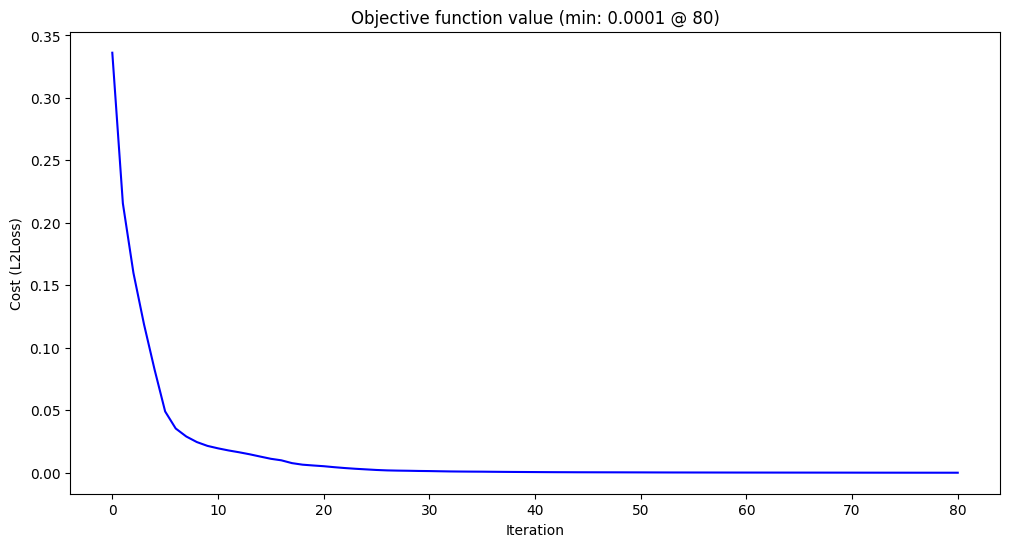

In [21]:
regr_callback.plot(
    ylabel = f'Cost ({loss_fun_name})',
    save_plot = f'{FIGURES_PATH}/train_{TRAIN_PREF}/hist_{loss_fun_name}.eps')

## Save training data

In [31]:
### Training info files 
train_info_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/info.json'
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/init.arr'
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/hist.arr'
params_fpath = f'{PARAMS_PATH}/{TRAIN_PREF}/params.arr'
train_info_fpath

'log_2/training/qnn_n70_z0_q9_in5_fm1_anz5_L_BFGS_B_ep80/info.json'

In [32]:
## Save training parameters
### Save info details
train_info = \
    {'case_name':CASE_NAME, 
     'major_version':MAJOR, 
     'minor_version':MINOR,
     'data_name':DATA_NAME,
     'data_sample':samples,
     'data_split':train_pc,
     'data_noise':noise,
     'ansatz_qubits':model.num_qubits,
     'ansatz_fm_layers':fm_layers,
     'ansatz_anz_layers':anz_layers,
     'ansatz_ent':ent,
     'log_interv':1,
     'opt_name':opt_name,
     'epochs':epochs,
     'shots':shots,
     'seed':seed}

### Saving the info file
write_json_file(train_info_fpath, train_info)
    
print(f'\nSaved time series info in file "{train_info_fpath}":\n')
for k in train_info.keys():
    print(f'\tinfo[{k}] = {train_info[k]}')
print()


Saved time series info in file "log_2/training/qnn_n70_z0_q9_in5_fm1_anz5_L_BFGS_B_ep80/info.json":

	info[case_name] = qnn
	info[major_version] = 9
	info[minor_version] = 0
	info[data_name] = 2_sins_sw
	info[data_sample] = 70
	info[data_split] = 0.7142857142857143
	info[data_noise] = 0
	info[ansatz_qubits] = 9
	info[ansatz_fm_layers] = 1
	info[ansatz_anz_layers] = 5
	info[ansatz_ent] = circular
	info[log_interv] = 1
	info[opt_name] = L_BFGS_B
	info[epochs] = 80
	info[shots] = 10000
	info[seed] = 2022



In [33]:
### Save the history file, init and training parameters
write_ts_file(init_fpath, init_weights)
write_ts_file(history_fpath, regr_callback.objfun_vals)
write_ts_file(params_fpath, regr_callback.params_vals)
print(f'Saved data shapes: init_weights={init_weights.shape}; '+\
      f'objfun_vals=({len(regr_callback.objfun_vals)},); '+\
      f'params_vals=({len(regr_callback.params_vals)}, {len(regr_callback.params_vals[0])})')

Saved data shapes: init_weights=(162,); objfun_vals=(81,); params_vals=(81, 162)


## System

In [34]:
!pip list | grep -e qiskit -e torch

qiskit                    1.2.4
qiskit-aer-gpu            0.15.1
qiskit-algorithms         0.3.1
qiskit-ibm-runtime        0.32.0
qiskit-machine-learning   0.7.2
qiskit-optimization       0.6.1
